In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split
from Parameters import Parameters

t = Parameters('DT').training_reg_params

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('DT')

In [3]:
X,Y = model.preprocessing.load_data('./Agg_data_from_frame_295.xlsx',labels=False,sheet_name="Sheet1")
Y_old = model.preprocessing.load_Y('../Updated_targets_300519.xlsx',video_name=False,column_name="diff")
Y_new = model.preprocessing.load_Y('../../Frame_Analysis/new_targets.xlsx',video_name=False,column_name="diff")

In [4]:
X = X.set_index(X['Video Name'])
# X = X.drop('Unnamed: 0',1)
Y_old['Video Name'] = Y_old.index.values
Y_new['Video Name'] = Y_new.index.values

Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
Y_new = Y_new.drop('Video Name',1)
Y = pd.concat((Y_old,Y_new),axis=1)
X = X.loc[X['Campaign']=='Surface']
Y = Y.loc[X.index.values,:]

In [5]:
Y.dropna(how='all')
X,Y= model.preprocessing.clean_data(X,Y)

In [6]:
surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
    cols = [col+suf for col in surface_pro_frames[:10]]
    X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
X = X.drop(surface_pro_frames,axis=1)

In [7]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
columns_removed.remove('Surface')

In [8]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['Female_frame_count',
 'Male_frame_count',
 'Age: 5-15_frame_count',
 'Age: 0-5_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell PCs',
 'Dell XPS',
 'Dell XPS 13',
 'HP Spectre x360',
 'HP Spectre x360, Windows',
 'Lenovo PCs',
 'Lenovo Yoga 720',
 'Lenovo Yoga 910',
 'MacBook Air',
 'MacBook Pro',
 'Macbook Air',
 'Microsoft Surface',
 'Suface Laptop',
 'Surface Book',
 'Surface Go',
 'Surface Laptop',
 'Surface Pen',
 'Surface laptop',
 'The surface Laptop',
 'Windows',
 'Windows 10',
 'Windows 10 PC',
 'Windows 10 PCs',
 'Windows 10, HP_Spectre',
 'Windows 10, Windows',
 'Yoga',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [9]:
new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-5_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-5_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
age_cols = ['Age: 5-15_dur', 'Age: 0-5_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
gender_cols = ["Female_dur","Male_dur"]
emotion_cols = ["Happiness_dur","Surprise_dur","Neutral_dur","Sadness_dur"]
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# X = model.preprocessing.addNewFeature(X,new_features,_type='per')
# X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [10]:
X = X.drop(age_cols,1)
X = X.drop(ethinicity_cols,1)
X = X.drop(gender_cols,1)
X = X.drop(emotion_cols,1)

In [11]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

Tablet_total_ocr    45.3125
Tablet_last_ocr     45.3125
Tablet_first_ocr    45.3125
Tablet_dur          45.3125
Laptop_total_ocr     7.8125
dtype: float64

In [12]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [13]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [14]:
# Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                    38
Brand_Cues__Mean                     0
Aided_Branding__Mean                 0
Active_Involvement__Mean             0
New_Information__Mean                0
Enjoyment__Mean                      0
Brand_Appeal__Mean                   0
Understanding__Mean                  0
Relevance_of_Information__Mean       0
Credibility_of_Information__Mean     0
Brand_Difference__Mean               0
Video Name                           0
Interest_peak                       37
Interest_mean_score                 37
Purchase_intent                      0
Persuasion_mean                      0
Persuasion_very_likely               0
Interest_peak_frames                37
dtype: int64

In [15]:
X.columns.values

array(['Video Name', 'length_of_ad_15', 'ad_type_tv', 'microsoft_dur',
       'microsoft_first_ocr', 'microsoft_last_ocr', 'microsoft_total_ocr',
       'ASUS T102_dur', 'Dell PCs_dur', 'Dell XPS_dur', 'Dell XPS 13_dur',
       'HP Spectre x360_dur', 'HP Spectre x360, Windows_dur',
       'Lenovo PCs_dur', 'Lenovo Yoga 720_dur', 'Lenovo Yoga 910_dur',
       'MacBook Air_dur', 'MacBook Pro_dur', 'Macbook Air_dur',
       'Microsoft Surface_dur', 'Suface Laptop_dur', 'Surface Book_dur',
       'Surface Go_dur', 'Surface Laptop_dur', 'Surface Pen_dur',
       'Surface laptop_dur', 'The surface Laptop_dur', 'Windows_dur',
       'Windows 10_dur', 'Windows 10 PC_dur', 'Windows 10 PCs_dur',
       'Windows 10, HP_Spectre_dur', 'Windows 10, Windows_dur',
       'Yoga_dur', 'Laptop_dur', 'Laptop_first_ocr', 'Laptop_last_ocr',
       'Laptop_total_ocr', 'Tablet_dur', 'Tablet_first_ocr',
       'Tablet_last_ocr', 'Tablet_total_ocr', 'Surface_dur',
       'Surface_first_ocr', 'Surface_last_ocr',

In [16]:
Y_14 = Y.loc[:,Y.isna().sum()==0]
Y_4 = Y.loc[:,Y.isna().sum()!=0]
X_4 = X[Y_4['Unaided_Branding'].isna()==False]
Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [17]:
X_res_14,Y_res_14 = model.preprocessing.overSampling(X,Y_14.drop('Video Name',1),each_Col=False,size=1000,random_state=12)
X_train_14,X_test_14,y_train_14,y_test_14 = train_test_split(X_res_14,Y_res_14,random_state = 123,test_size=0.3)

X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [20]:
# print("------------------------ 14 Models Training ----------------------------\n")
# models_14 = model.train(X_train_14,y_train_14,X_test_14,y_test_14,metrics='r2',plot_error=False,set_params=True,params=t)
print("------------------------ 4 Models Training ----------------------------\n")
models_4 = model.train(X_train_4,y_train_4,X_test_4,y_test_4,metrics='r2',plot_error=False)

------------------------ 4 Models Training ----------------------------

Unaided_Branding
For training set
r2_score: 0.927824
For test set
r2_score: 0.880010


Interest_peak
For training set
r2_score: 0.812237
For test set
r2_score: 0.755976


Interest_mean_score
For training set
r2_score: 0.876995
For test set
r2_score: 0.901900


Interest_peak_frames
For training set
r2_score: 0.812237
For test set
r2_score: 0.755976




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [21]:
model.plot_tree(savefig=True)

Brand_Cues__Mean
Feature ranking:
microsoft_first_ocr
Neutral_dur
Surface Go_dur
Laptop_dur
microsoft_total_ocr
Neutral_Age: 25-34_dur
African_dur
Male_dur
Age: 25-34_Eastasian_dur
Tablet_first_ocr
Tablet_total_ocr
Tablet_dur
microsoft_dur
Tablet_last_ocr
Laptop_first_ocr
Laptop_total_ocr
Laptop_last_ocr
Surface_first_ocr
Caucasian_dur
Surface_last_ocr
Neutral_Male_dur
Age: 25-34_dur
Age: 35-44_dur
Eastasian_dur
Surface laptop_dur
Sadness_dur
Happiness_Female_dur
Age: 25-34_Caucasian_dur
Surface Pen_dur
Happiness_Eastasian_dur
microsoft_last_ocr
Surface_total_ocr
Female_dur
Surface Book_dur
Surface Laptop_dur
Happiness_dur
Happiness_length_of_ad_impact
Surface_dur
Age: 35-44_Eastasian_dur
Microsoft Surface_dur
length_of_ad_15
Suface Laptop_dur
MacBook Air_dur
MacBook Pro_dur
ad_type_tv
The surface Laptop_dur
Macbook Air_dur
Windows 10 PC_dur
Lenovo Yoga 720_dur
Lenovo PCs_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
HP Spectre x360_dur
Windows 10_d

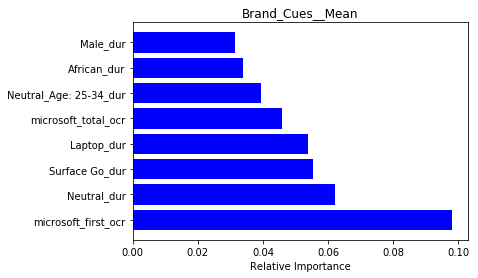

Aided_Branding__Mean
Feature ranking:
Surface Go_dur
Laptop_total_ocr
Happiness_Female_dur
African_dur
microsoft_total_ocr
Laptop_dur
Neutral_dur
microsoft_first_ocr
Sadness_dur
Tablet_last_ocr
Laptop_last_ocr
Neutral_Male_dur
Tablet_total_ocr
Surface_first_ocr
Neutral_Age: 25-34_dur
Age: 25-34_dur
microsoft_last_ocr
Tablet_first_ocr
microsoft_dur
Surface Book_dur
Female_dur
Laptop_first_ocr
Happiness_dur
Caucasian_dur
Happiness_Eastasian_dur
Tablet_dur
Male_dur
Eastasian_dur
Surface laptop_dur
Surface_last_ocr
Age: 25-34_Caucasian_dur
Surface_dur
Surface Laptop_dur
Microsoft Surface_dur
Happiness_length_of_ad_impact
Age: 25-34_Eastasian_dur
Surface Pen_dur
Surface_total_ocr
Age: 35-44_dur
length_of_ad_15
Age: 35-44_Eastasian_dur
MacBook Air_dur
MacBook Pro_dur
Macbook Air_dur
The surface Laptop_dur
ad_type_tv
Suface Laptop_dur
Windows 10 PC_dur
Yoga_dur
Lenovo Yoga 910_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Lenovo PCs_dur
Windows 10_dur
HP Spectre x3

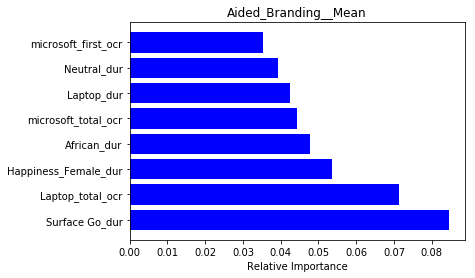

Active_Involvement__Mean
Feature ranking:
microsoft_first_ocr
length_of_ad_15
microsoft_last_ocr
Laptop_total_ocr
Laptop_dur
Tablet_first_ocr
Laptop_last_ocr
microsoft_total_ocr
Age: 25-34_Eastasian_dur
Caucasian_dur
Tablet_dur
Tablet_last_ocr
microsoft_dur
Tablet_total_ocr
Neutral_dur
Neutral_Male_dur
Age: 25-34_dur
Happiness_Eastasian_dur
Laptop_first_ocr
Neutral_Age: 25-34_dur
Male_dur
Happiness_Female_dur
Happiness_length_of_ad_impact
The surface Laptop_dur
Age: 25-34_Caucasian_dur
Female_dur
Eastasian_dur
Age: 35-44_Eastasian_dur
Happiness_dur
Surface Laptop_dur
Surface_dur
Surface Go_dur
Surface_last_ocr
Surface laptop_dur
Surface_first_ocr
Sadness_dur
Age: 35-44_dur
African_dur
Surface Book_dur
Surface_total_ocr
Macbook Air_dur
ad_type_tv
MacBook Pro_dur
Surface Pen_dur
Microsoft Surface_dur
MacBook Air_dur
Suface Laptop_dur
Yoga_dur
Windows 10 PCs_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Windows 10 PC_dur
HP Spectre x360_dur

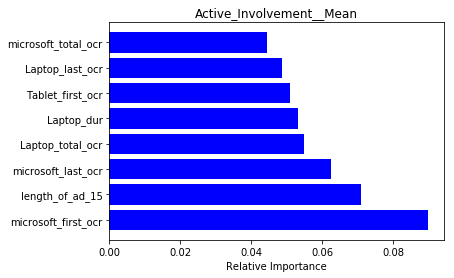

New_Information__Mean
Feature ranking:
Tablet_first_ocr
Surface_total_ocr
Tablet_last_ocr
Tablet_total_ocr
Laptop_last_ocr
Surface_dur
Tablet_dur
Age: 25-34_dur
microsoft_last_ocr
Surface Go_dur
Laptop_total_ocr
Neutral_dur
Neutral_Age: 25-34_dur
African_dur
Caucasian_dur
Neutral_Male_dur
Age: 25-34_Caucasian_dur
Male_dur
Laptop_first_ocr
microsoft_dur
Happiness_Eastasian_dur
Sadness_dur
Laptop_dur
microsoft_total_ocr
microsoft_first_ocr
Female_dur
Happiness_Female_dur
length_of_ad_15
Surface Book_dur
Age: 25-34_Eastasian_dur
Microsoft Surface_dur
Surface_first_ocr
Eastasian_dur
Surface Laptop_dur
Surface_last_ocr
Age: 35-44_dur
Happiness_dur
Age: 35-44_Eastasian_dur
Happiness_length_of_ad_impact
MacBook Air_dur
Surface laptop_dur
Surface Pen_dur
ad_type_tv
MacBook Pro_dur
The surface Laptop_dur
Macbook Air_dur
Suface Laptop_dur
HP Spectre x360, Windows_dur
Windows 10, Windows_dur
Lenovo Yoga 910_dur
Lenovo Yoga 720_dur
Yoga_dur
Windows 10, HP_Spectre_dur
HP Spectre x360_dur
Lenovo PCs

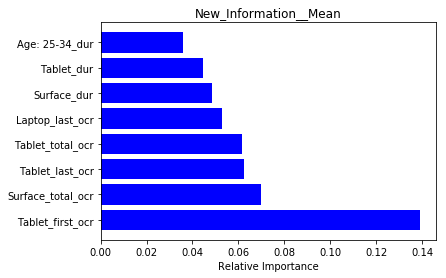

Enjoyment__Mean
Feature ranking:
Surface_total_ocr
Surface_last_ocr
microsoft_last_ocr
Surface_first_ocr
Surface_dur
Caucasian_dur
microsoft_total_ocr
length_of_ad_15
Neutral_dur
Laptop_first_ocr
Neutral_Age: 25-34_dur
microsoft_first_ocr
Tablet_last_ocr
Age: 35-44_Eastasian_dur
Laptop_dur
Happiness_dur
Laptop_total_ocr
Tablet_first_ocr
Laptop_last_ocr
Age: 25-34_dur
Happiness_Eastasian_dur
Neutral_Male_dur
Sadness_dur
Happiness_length_of_ad_impact
Happiness_Female_dur
Female_dur
microsoft_dur
Male_dur
Tablet_dur
Age: 25-34_Caucasian_dur
African_dur
Eastasian_dur
Tablet_total_ocr
Age: 25-34_Eastasian_dur
Age: 35-44_dur
Surface Book_dur
Surface Go_dur
The surface Laptop_dur
Surface Laptop_dur
Macbook Air_dur
Surface Pen_dur
MacBook Air_dur
ad_type_tv
MacBook Pro_dur
Surface laptop_dur
Microsoft Surface_dur
Suface Laptop_dur
Yoga_dur
Windows 10 PC_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Windows 10_dur
HP Spectre x360_dur
HP Spectre x

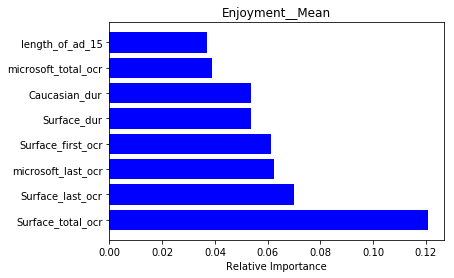

Brand_Appeal__Mean
Feature ranking:
Surface_last_ocr
microsoft_last_ocr
Surface_total_ocr
Surface_dur
microsoft_first_ocr
length_of_ad_15
African_dur
Surface_first_ocr
Neutral_dur
Caucasian_dur
microsoft_total_ocr
Laptop_last_ocr
Tablet_first_ocr
Female_dur
Happiness_length_of_ad_impact
Surface Book_dur
Age: 25-34_Caucasian_dur
Happiness_Eastasian_dur
Laptop_total_ocr
Laptop_dur
Sadness_dur
MacBook Pro_dur
Tablet_dur
Neutral_Male_dur
Age: 25-34_dur
microsoft_dur
Neutral_Age: 25-34_dur
Tablet_last_ocr
Happiness_dur
Age: 25-34_Eastasian_dur
Happiness_Female_dur
Male_dur
Laptop_first_ocr
Surface laptop_dur
ad_type_tv
Tablet_total_ocr
Age: 35-44_dur
Eastasian_dur
Microsoft Surface_dur
Surface Go_dur
Age: 35-44_Eastasian_dur
Surface Laptop_dur
The surface Laptop_dur
MacBook Air_dur
Surface Pen_dur
Suface Laptop_dur
Macbook Air_dur
Windows_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Lenovo PCs_dur
HP Spectre x360, Window

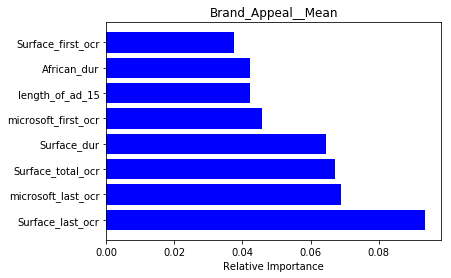

Understanding__Mean
Feature ranking:
African_dur
Caucasian_dur
Laptop_first_ocr
Laptop_dur
Surface Go_dur
microsoft_total_ocr
microsoft_first_ocr
Age: 25-34_Caucasian_dur
Tablet_dur
Male_dur
Laptop_total_ocr
Age: 25-34_dur
Happiness_Female_dur
Neutral_Male_dur
Tablet_first_ocr
Neutral_dur
Tablet_total_ocr
Laptop_last_ocr
microsoft_last_ocr
Tablet_last_ocr
Female_dur
microsoft_dur
Happiness_Eastasian_dur
Sadness_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Happiness_dur
Surface_total_ocr
Age: 25-34_Eastasian_dur
Age: 35-44_dur
Surface_first_ocr
Happiness_length_of_ad_impact
Surface_last_ocr
Surface_dur
Surface Laptop_dur
Age: 35-44_Eastasian_dur
Surface Book_dur
Surface laptop_dur
MacBook Air_dur
Surface Pen_dur
Microsoft Surface_dur
length_of_ad_15
The surface Laptop_dur
MacBook Pro_dur
ad_type_tv
Macbook Air_dur
Suface Laptop_dur
Windows 10 PC_dur
Lenovo Yoga 720_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
HP Spectre x360_dur
Dell XPS 13_dur
Windows_

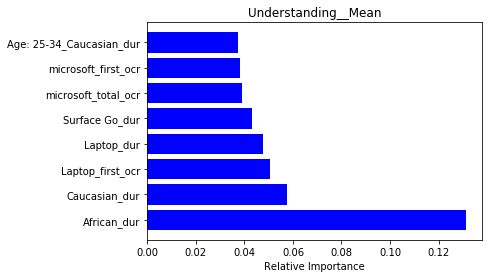

Relevance_of_Information__Mean
Feature ranking:
Surface Book_dur
microsoft_total_ocr
Male_dur
Surface_first_ocr
Surface_total_ocr
Laptop_total_ocr
Tablet_total_ocr
microsoft_last_ocr
Laptop_first_ocr
Tablet_last_ocr
Neutral_Age: 25-34_dur
Tablet_dur
Surface_dur
Age: 25-34_dur
Surface Go_dur
Surface_last_ocr
Tablet_first_ocr
Caucasian_dur
Surface Pen_dur
microsoft_first_ocr
Happiness_dur
Age: 25-34_Eastasian_dur
African_dur
Laptop_dur
Female_dur
Laptop_last_ocr
Neutral_dur
Happiness_Eastasian_dur
Neutral_Male_dur
Age: 25-34_Caucasian_dur
microsoft_dur
Eastasian_dur
Happiness_Female_dur
length_of_ad_15
Happiness_length_of_ad_impact
MacBook Pro_dur
Surface Laptop_dur
Sadness_dur
ad_type_tv
Age: 35-44_dur
Age: 35-44_Eastasian_dur
Microsoft Surface_dur
Surface laptop_dur
Macbook Air_dur
MacBook Air_dur
The surface Laptop_dur
Suface Laptop_dur
Windows 10 PCs_dur
Lenovo Yoga 720_dur
Lenovo PCs_dur
Yoga_dur
Windows 10, Windows_dur
HP Spectre x360, Windows_dur
Windows 10, HP_Spectre_dur
Dell PC

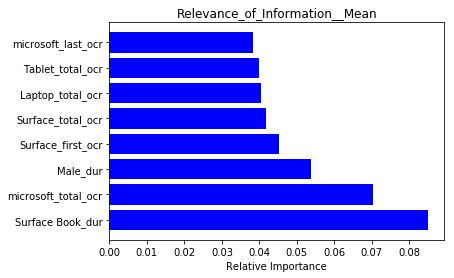

Credibility_of_Information__Mean
Feature ranking:
Surface Go_dur
Male_dur
Laptop_last_ocr
Surface_first_ocr
Caucasian_dur
Age: 25-34_Caucasian_dur
microsoft_total_ocr
Surface_total_ocr
Laptop_dur
Surface_last_ocr
ad_type_tv
Surface_dur
microsoft_first_ocr
Laptop_total_ocr
MacBook Pro_dur
Laptop_first_ocr
Neutral_dur
Age: 25-34_Eastasian_dur
Tablet_first_ocr
Surface Book_dur
Tablet_total_ocr
Neutral_Male_dur
Neutral_Age: 25-34_dur
Happiness_dur
Eastasian_dur
Age: 25-34_dur
Happiness_Female_dur
Tablet_last_ocr
Tablet_dur
Surface Pen_dur
Happiness_length_of_ad_impact
Sadness_dur
microsoft_last_ocr
African_dur
microsoft_dur
Female_dur
Happiness_Eastasian_dur
Age: 35-44_dur
Microsoft Surface_dur
MacBook Air_dur
Age: 35-44_Eastasian_dur
Surface laptop_dur
Surface Laptop_dur
length_of_ad_15
Macbook Air_dur
Suface Laptop_dur
The surface Laptop_dur
Dell XPS_dur
Lenovo Yoga 720_dur
Yoga_dur
Lenovo Yoga 910_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Lenovo PCs_dur
Dell PCs_dur
Windows

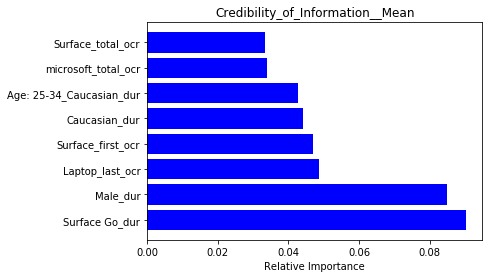

Brand_Difference__Mean
Feature ranking:
microsoft_last_ocr
length_of_ad_15
Tablet_first_ocr
Laptop_last_ocr
microsoft_first_ocr
Tablet_last_ocr
microsoft_total_ocr
Happiness_length_of_ad_impact
Caucasian_dur
Neutral_Male_dur
Neutral_dur
Laptop_total_ocr
Age: 25-34_dur
Tablet_total_ocr
Laptop_dur
microsoft_dur
Age: 25-34_Caucasian_dur
Surface_first_ocr
Surface_last_ocr
Tablet_dur
Happiness_dur
African_dur
Neutral_Age: 25-34_dur
Laptop_first_ocr
Age: 25-34_Eastasian_dur
Happiness_Female_dur
Surface Book_dur
Surface_total_ocr
Female_dur
Eastasian_dur
Sadness_dur
Happiness_Eastasian_dur
Age: 35-44_Eastasian_dur
Surface_dur
Male_dur
Surface Go_dur
Surface Laptop_dur
Age: 35-44_dur
Microsoft Surface_dur
Surface laptop_dur
MacBook Pro_dur
ad_type_tv
MacBook Air_dur
The surface Laptop_dur
Surface Pen_dur
Suface Laptop_dur
Macbook Air_dur
Lenovo PCs_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Lenovo Yoga 720_dur
HP Spectre x360_dur
Windows_dur
Windows 10_dur
Windows 10 PC_dur
Windows 10 PCs_dur

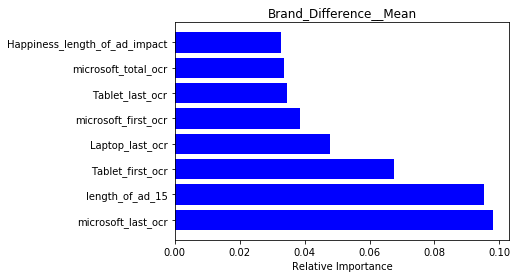

Purchase_intent
Feature ranking:
microsoft_first_ocr
Surface Laptop_dur
microsoft_total_ocr
Surface laptop_dur
Laptop_total_ocr
Tablet_dur
Surface Go_dur
Neutral_dur
Laptop_first_ocr
Age: 25-34_Eastasian_dur
Tablet_total_ocr
Laptop_last_ocr
Tablet_last_ocr
Surface_first_ocr
microsoft_dur
Surface_dur
Surface Book_dur
Surface_last_ocr
Happiness_length_of_ad_impact
Surface_total_ocr
Neutral_Male_dur
Happiness_dur
Tablet_first_ocr
microsoft_last_ocr
Male_dur
Age: 35-44_Eastasian_dur
Neutral_Age: 25-34_dur
Laptop_dur
Eastasian_dur
Age: 35-44_dur
Age: 25-34_dur
Sadness_dur
Female_dur
length_of_ad_15
Caucasian_dur
Happiness_Female_dur
Age: 25-34_Caucasian_dur
Happiness_Eastasian_dur
African_dur
ad_type_tv
MacBook Pro_dur
Suface Laptop_dur
MacBook Air_dur
Surface Pen_dur
Microsoft Surface_dur
Macbook Air_dur
The surface Laptop_dur
Windows_dur
Lenovo Yoga 910_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Dell PCs_dur
ASUS T102_dur
Len

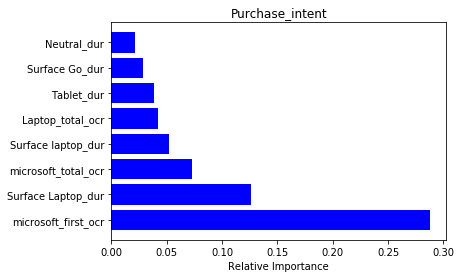

Persuasion_mean
Feature ranking:
microsoft_first_ocr
Age: 25-34_Eastasian_dur
microsoft_total_ocr
Caucasian_dur
Laptop_dur
microsoft_dur
Neutral_dur
Laptop_total_ocr
Laptop_last_ocr
Tablet_dur
Neutral_Age: 25-34_dur
Tablet_total_ocr
Tablet_first_ocr
Laptop_first_ocr
Age: 25-34_Caucasian_dur
Age: 25-34_dur
microsoft_last_ocr
Age: 35-44_Eastasian_dur
Tablet_last_ocr
Happiness_length_of_ad_impact
Eastasian_dur
Female_dur
Male_dur
Neutral_Male_dur
Surface_dur
length_of_ad_15
Sadness_dur
Happiness_Eastasian_dur
Happiness_dur
Surface_last_ocr
Happiness_Female_dur
Age: 35-44_dur
Surface_first_ocr
Surface Laptop_dur
Surface Go_dur
Surface laptop_dur
Surface_total_ocr
African_dur
MacBook Air_dur
Surface Book_dur
MacBook Pro_dur
Macbook Air_dur
Microsoft Surface_dur
The surface Laptop_dur
ad_type_tv
Surface Pen_dur
Suface Laptop_dur
Windows 10, HP_Spectre_dur
Yoga_dur
Windows 10, Windows_dur
Windows_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS 13_du

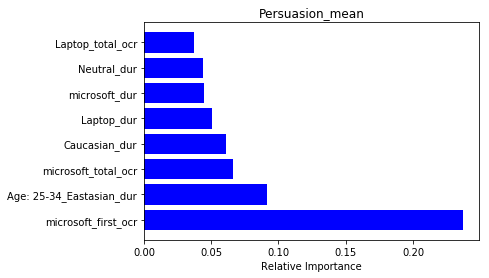

Persuasion_very_likely
Feature ranking:
microsoft_first_ocr
Age: 25-34_Eastasian_dur
microsoft_total_ocr
microsoft_dur
Laptop_dur
Laptop_total_ocr
Laptop_last_ocr
Caucasian_dur
Neutral_dur
Neutral_Age: 25-34_dur
Tablet_dur
Tablet_first_ocr
Age: 25-34_dur
Laptop_first_ocr
Surface_dur
microsoft_last_ocr
Age: 25-34_Caucasian_dur
Neutral_Male_dur
Eastasian_dur
Tablet_total_ocr
Age: 35-44_Eastasian_dur
Male_dur
Tablet_last_ocr
Female_dur
length_of_ad_15
Sadness_dur
Surface_first_ocr
Surface_total_ocr
Happiness_Eastasian_dur
Surface_last_ocr
Happiness_Female_dur
Happiness_length_of_ad_impact
Happiness_dur
Age: 35-44_dur
African_dur
Surface Go_dur
Surface Laptop_dur
Surface laptop_dur
Surface Book_dur
Surface Pen_dur
The surface Laptop_dur
MacBook Air_dur
ad_type_tv
MacBook Pro_dur
Macbook Air_dur
Microsoft Surface_dur
Suface Laptop_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
HP Spectre x360, Windows_dur
HP Spectre x360_dur
Windows_dur


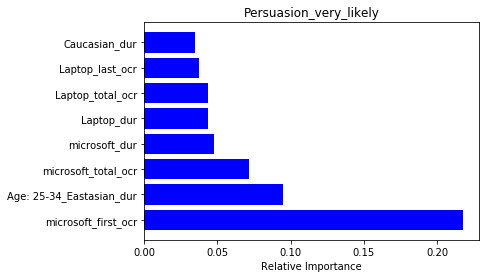

In [27]:
model.plot_feature_importance(models_14,10,y_train_14.columns,X_train_14.columns,savefig=False)

Unaided_Branding
Feature ranking:
microsoft_first_ocr
Laptop_first_ocr
microsoft_dur
Happiness_dur
Laptop_total_ocr
Age: 25-34_Eastasian_dur
Age: 25-34_dur
Surface_total_ocr
Surface_dur
Tablet_last_ocr
Tablet_dur
Happiness_length_of_ad_impact
African_dur
Surface Book_dur
Caucasian_dur
Laptop_dur
microsoft_last_ocr
Age: 25-34_Caucasian_dur
Male_dur
Sadness_dur
Female_dur
Laptop_last_ocr
microsoft_total_ocr
Surface_first_ocr
Happiness_Eastasian_dur
Neutral_Male_dur
Age: 35-44_Eastasian_dur
Surface_last_ocr
Happiness_Female_dur
Eastasian_dur
Neutral_dur
Tablet_total_ocr
Tablet_first_ocr
length_of_ad_15
Neutral_Age: 25-34_dur
Age: 35-44_dur
Surface Pen_dur
MacBook Air_dur
Macbook Air_dur
ad_type_tv
MacBook Pro_dur
Microsoft Surface_dur
The surface Laptop_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
Surface Laptop_dur
Surface laptop_dur
Suface Laptop_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur

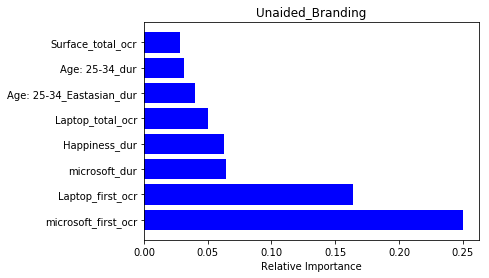

Interest_peak
Feature ranking:
Macbook Air_dur
Neutral_Male_dur
Neutral_Age: 25-34_dur
Happiness_Female_dur
Female_dur
Happiness_dur
Surface_first_ocr
Age: 25-34_dur
Surface_last_ocr
Laptop_last_ocr
Laptop_dur
Age: 25-34_Caucasian_dur
Laptop_total_ocr
Caucasian_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Surface_dur
microsoft_last_ocr
Tablet_first_ocr
Male_dur
Tablet_total_ocr
African_dur
Neutral_dur
Age: 35-44_dur
microsoft_total_ocr
Age: 25-34_Eastasian_dur
Surface_total_ocr
microsoft_dur
Laptop_first_ocr
Age: 35-44_Eastasian_dur
Happiness_length_of_ad_impact
Happiness_Eastasian_dur
Surface Book_dur
Sadness_dur
Eastasian_dur
length_of_ad_15
Surface Pen_dur
ad_type_tv
MacBook Pro_dur
MacBook Air_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Lenovo Yoga 910_dur
Suface Laptop_dur
Microsoft Surface_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_du

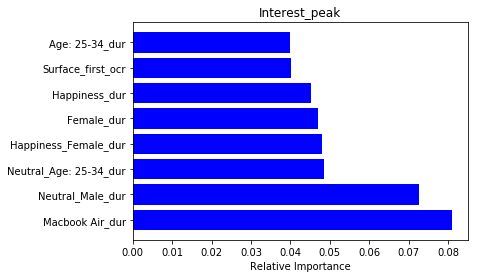

Interest_mean_score
Feature ranking:
Surface_dur
microsoft_first_ocr
Surface_total_ocr
Age: 25-34_dur
Sadness_dur
Neutral_Male_dur
microsoft_last_ocr
Laptop_first_ocr
microsoft_dur
Surface_first_ocr
Laptop_total_ocr
Caucasian_dur
Happiness_dur
Surface Book_dur
Laptop_last_ocr
Surface_last_ocr
Neutral_dur
Laptop_dur
Tablet_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Female_dur
Male_dur
Tablet_first_ocr
Tablet_total_ocr
microsoft_total_ocr
African_dur
length_of_ad_15
Surface Pen_dur
Tablet_last_ocr
Macbook Air_dur
Happiness_length_of_ad_impact
Age: 25-34_Caucasian_dur
Age: 25-34_Eastasian_dur
Age: 35-44_Eastasian_dur
Age: 35-44_dur
Happiness_Eastasian_dur
MacBook Air_dur
Happiness_Female_dur
ad_type_tv
MacBook Pro_dur
Surface Laptop_dur
Windows 10_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
The surface Laptop_dur
Windows_dur
Suface Laptop_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, 

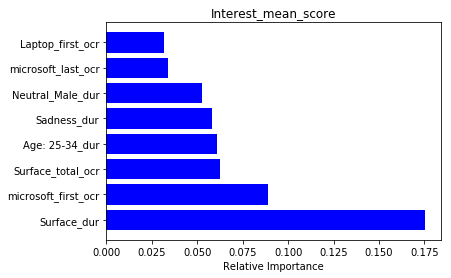

Interest_peak_frames
Feature ranking:
Macbook Air_dur
Neutral_Male_dur
Happiness_Female_dur
Neutral_Age: 25-34_dur
Female_dur
Surface_first_ocr
Age: 25-34_dur
Surface_last_ocr
Happiness_dur
Laptop_last_ocr
Laptop_dur
Laptop_total_ocr
Age: 25-34_Caucasian_dur
Caucasian_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Tablet_first_ocr
Surface_dur
microsoft_last_ocr
Male_dur
Tablet_total_ocr
Neutral_dur
African_dur
microsoft_total_ocr
Age: 35-44_dur
Age: 25-34_Eastasian_dur
microsoft_dur
Laptop_first_ocr
Surface_total_ocr
Happiness_Eastasian_dur
Surface Book_dur
Happiness_length_of_ad_impact
Age: 35-44_Eastasian_dur
Eastasian_dur
Sadness_dur
length_of_ad_15
Surface Pen_dur
MacBook Pro_dur
ad_type_tv
MacBook Air_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Lenovo Yoga 910_dur
Suface Laptop_dur
Microsoft Surface_dur
ASUS T102_dur
Dell PCs_dur
Dell

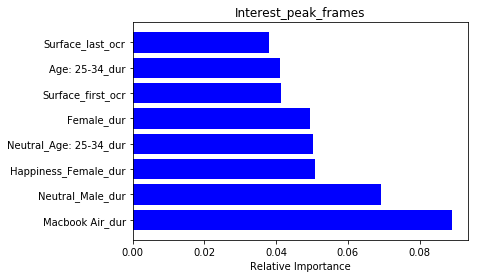

In [28]:
model.plot_feature_importance(models_4,10,y_train_4.columns,X_train_4.columns,savefig=False)

In [62]:
shap.initjs()
explainer=[]
shap_values=[]
for i in range(4):
    explainer.append(shap.TreeExplainer(models_4[i]))
    shap_values.append(explainer[-1].shap_values(X_train_4))
    print(i)

0
1
2
3


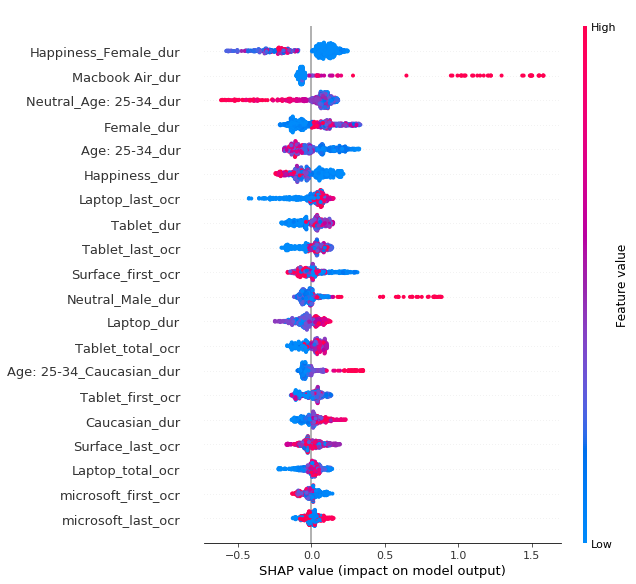

In [70]:
shap.summary_plot(shap_values[3],X_train_4)

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')